# Walk Forward Analysis (Framework)
### Abstract:
Walk forward analysis (WFA), or walk forward optimization (WFO) is a method used to optimize trading strategies. It involves dividing historical data into segments and testing the strategy on each segment, then re-optimizing the parameters for the next segment. This ensures that the strategy adapts to changing market conditions and avoids overfitting.

### Doing it with TradingView's deep-backtesting feature:
TradingView does not provide this feature, so we need to manually obtain in-sample datasets (see prerequisites section below). After the manual process is complete, we can use Python to combine the Out of Sample periods (OOS) and visualize the performance of a strategy that had adopted different settings over historical time.

### Prerequisites:
Before running this script, you should have:
* A TradingView Premium account for accessing the "deep backtesting" feature and setting in-sample periods. This allows you to manually tested all combinations of strategy settings for in-sample periods.
* A dataset containing in-sample trade performance. In this notebook, we are using "List_of_Trades" .csv file that is generated by TradingView's built-in backtester.

### Example Strategy:
Here are the properties of the strategy used for illustrative purposes:
* Trend following, adds to existing winning position
* Risking USD1 per NASDAQ point movement (think of a "Half MNQ". You will multiply the results by 2 if you're trading MNQ, and 20 if it's NQ)
* Session: 0945-1545 EST

##### Strat Settings

* In this WFO, we will adjust the "brick size" parameters on a weekly basis to optimize the in-sample (IS) periods. Rest are fixed.
* Out-of-sample periods will follow IS by taking the average of args on a rolling basis. Surely, there must be more clever ways to do it by appling ML, but I'm not an expert in this domain of practice.

# Setup:

In [1]:
# Source: Backtest reports exported from TradingView

# Note: The purpose of this notebook is to illustrate the framework for walk forward analysis. 
# The actual source files, as indexed by repo_list, are not included in the repository. 
repo_list = [   r"Dataset 004.repo/Dataset 004_batch1.repo",
                r"Dataset 004.repo/Dataset 004_batch2.repo/revised 20231007"]

VERBOSE         = False

# Field names
PARAM1_BRICK    = "Volatility Filter: Brick size threshold" 

# String representation of parameters for grouping datasets
STR_PARMS       = "ATR={}; Brick={}" 

# Out of sample period (in weeks)
OOS_LOOKBACK    = 8 

In [2]:
import datetime
import os
import random

import regex as re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [3]:
dir_notebook_location = os.getcwd() # Location of this notebook

# Helper functions (All sections)

In [4]:
# --------------------- #
# Preprocessing 
# --------------------- #

def _clean_data(df_listoftrades):
    ''' Helper function to clean df_consol_trades. '''
    df_listoftrades = df_listoftrades[df_listoftrades['Type'].str.contains("Exit", na=False)] # Becuase we only want the exit trades, and since entry rows also contain the profit value, including it will cause double count issues
    df_listoftrades = df_listoftrades.astype({'Date/Time': 'datetime64[ns]'})
    _irrelevant_columns = ['Profit %', 'Cum. Profit USD', 'Cum. Profit %', 'Run-up USD', 'Run-up %', 'Drawdown USD', 'Drawdown %', 'Trade #']
    df_listoftrades = df_listoftrades.drop(columns=_irrelevant_columns)
    df_listoftrades = df_listoftrades.sort_index(ascending=False)
    df_listoftrades = df_listoftrades.sort_values(by="Date/Time", ascending=True)

    return df_listoftrades

def _categorize_in_sample(date):
    ''' Helper function to categorize in-sample group based on given date. '''
    year, week_num, day_of_week = date.isocalendar()
    return str(year) + "_Week #{:02d}".format(week_num)

def _build_df_main(path='.'): 
    _df_consol_trades = []
    # Read the properties file and trades file and consolidate them into one dataframe
    os.chdir(path)
    for folder in os.listdir('.'): 

        # Iterate through subfolders && Search element in os.listdir(folder) that contains "_Properties_" and ".csv" 
        if os.path.isdir(folder): 
            print("Current path: {}/{}".format(path,folder), end="\r")
            for file in os.listdir(folder):
                if file.endswith(".csv") and "_Properties_" in file:
                    file_properties = os.path.join(folder, file) 
                elif file.endswith(".csv") and "_List_of_Trades_" in file:
                    file_trades = os.path.join(folder, file)   

            # Read the properties file. Followed by checking data integrity.
            df = pd.read_csv(file_properties)
            df.set_index("Title", inplace=True)
            df = df.T 
            
            _atr_len = 2 # int(df[PARAM2_ATRLEN].iloc[0])
            _brick_limit = int(df[PARAM1_BRICK].iloc[0])
            assert folder == str(_atr_len) + "_" + str(_brick_limit),\
                "Folder name does not correspond to arguments in properties file; folder={}".format(folder)
            
            # Read the trade file 
            df_sub = pd.read_csv(file_trades) 
            df_sub['Params'] = STR_PARMS.format(_atr_len, _brick_limit)
            _df_consol_trades.append(df_sub)

    df_main = _clean_data(pd.concat(_df_consol_trades, ignore_index=True))

    # -----------------------------------------------
    # Categorize in-sample group based on given date
    # -----------------------------------------------

    # Add week number
    df_main.dropna(subset=['Date/Time'], inplace=True)
    df_main['In-sample Group'] = df_main['Date/Time'].apply(lambda x: _categorize_in_sample(x)) 
    df_main.reset_index(inplace=True)

    # Aggregated by "in-sample group and params" and summed by "profit usd"
    df_main["In-sample Group + Params"] = df_main["In-sample Group"].astype(str) + " / " + df_main["Params"].astype(str)
    df_main.groupby("In-sample Group + Params").agg({"Profit USD": "sum"}).reset_index()
    df_main["Unique ID"] = df_main["Date/Time"].astype(str) + "___" + df_main["Params"] + df_main["Profit USD"].astype(str)
    df_main.drop(columns=["index"], inplace=True)
    
    return df_main

In [5]:
# ------------------------------------- #
# Optimization - Out-of-sample periods
# ------------------------------------- #

def _yyyy_weekNo_to_date(year, week_number): 
    d = str(year) + '-W' + str(week_number)
    r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return r.strftime('%Y-%m-%d')

def _find_nearest(array, value):
    if value is None or np.isnan(value):
        return None 

    # Find the element in array that is closest to value
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [6]:
# ------------------------------------- #
# Results 
# ------------------------------------- #

def _plot_equity_curve(df, remarks="", figsize=(15,3)):
    
    # Add remarks to title, if any
    if remarks != "":
        remarks = "\n" + remarks
    
    # Plot #1: Equity Curve
    plt.figure(figsize=figsize)
    plt.plot(df['Accum PL'], label="Combined Out-of-samples")
    title = "Equity Curve" + remarks
    plt.title(title, size=15)
    plt.xlabel("Date")
    plt.ylabel("Profits")
    plt.xticks(rotation=45)
    plt.legend(loc="upper left")

    # Plot #2: Drawdown underwater plot
    plt.figure(figsize=figsize)
    plt.plot(df["Drawdown"], color="red", alpha=0.85)
    plt.title("Drawdowns", size=15)
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.xticks(rotation=45)

    plt.show()


def _monte_carlo_equity_curve(df_listoftrades, n_simulations=1000, n_forecast=100):
    _equity_curves = []
    for _ in range(n_simulations):
        _equity_curve = [0]
        for _ in range(n_forecast):
            _equity_curve.append(_equity_curve[-1] + random.choice(df_listoftrades["Profit USD"].values))
        _equity_curves.append(_equity_curve)
    return _equity_curves


## Preprocessing

* Iterate through folders. Naming convention is "arg1"_"arg2"; where: arg1 is "ATR length", and arg2 is "Volatility filter"; 
* Result -> df_main

In [7]:
_list_dfs = [] # temp. list of dataframes, contains duplicated rows
for e in repo_list:
    _list_dfs.append(_build_df_main(e))

os.chdir(dir_notebook_location)
df_main = pd.concat(_list_dfs, axis=0, ignore_index=True)
df_main.drop_duplicates(subset='Unique ID', keep='first', inplace=True) # Remove duplicates according to column 'Unique ID'
print("Cleaned dataframe; shape={}:".format(df_main.shape))
df_main.head()

Cleaned dataframe; shape=(213199, 10):/Backtest WFA Data/Dataset 004.repo/Dataset 004_batch2.repo/revised 20231007/2_18


,Type,Signal,Date/Time,Price USD,Contracts,Profit USD,Params,In-sample Group,In-sample Group + Params,Unique ID
0,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=50,2014_Week #31,2014_Week #31 / ATR=2; Brick=50,2014-07-28 11:10:00___ATR=2; Brick=50-10.0
1,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=14,2014_Week #31,2014_Week #31 / ATR=2; Brick=14,2014-07-28 11:10:00___ATR=2; Brick=14-10.0
2,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=45,2014_Week #31,2014_Week #31 / ATR=2; Brick=45,2014-07-28 11:10:00___ATR=2; Brick=45-10.0
3,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=44,2014_Week #31,2014_Week #31 / ATR=2; Brick=44,2014-07-28 11:10:00___ATR=2; Brick=44-10.0
4,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-13.6,ATR=2; Brick=11,2014_Week #31,2014_Week #31 / ATR=2; Brick=11,2014-07-28 11:10:00___ATR=2; Brick=11-13.6


In [8]:
# Manual validation:
df_main[df_main['Params']=='ATR=2; Brick=30']['Profit USD'].sum()

9237.600000000002

In [9]:
print("Types of Entries: {}".format(str(set(df_main['Signal']))))
print("Type of Exits: {}".format(str(set(df_main['Type']))))

Types of Entries: {'end', 'SL - Potential News', 'Too volat.', 'TP - Potential News', 'Reverse'}
Type of Exits: {'Exit Long', 'Exit Short'}


## Optimizing IS stages + building OOS Template:
* Based on df_main
* Result -> df_wfa_template; a dataframe containing optimized parameters for the in-sample periods

In [10]:
_list_grouping  = []
_list_bricksize = []
_list_atrlen    = []
_list_benchmark = []

_count = 0
_total_count = len(df_main["In-sample Group"].unique())

# Iterate by In-sample Group (e) and "In-sample Group + Params" (f)
for e in df_main["In-sample Group"].unique():
    _count += 1
    print("Processing: {}/{}".format(_count, _total_count), end="\r")
    if VERBOSE:
        print("\nIn-sample period: " + e)
    tmp = df_main[df_main["In-sample Group"] == e]
    
    # Find best performance
    __best_benchmark = None
    __best_group = None # String representation of params: e "Brick=20, ATR=5"

    for f in tmp["In-sample Group + Params"].unique():
        __serr = tmp[tmp["In-sample Group + Params"] == f]["Profit USD"]
        _median = __serr.median()
        # _sharpe = __serr.mean() / __serr.std()
        benchmark = _median 
        
        if VERBOSE:
            print(">>> {} \tMedian={},\tbenchmark={}".format(f, _median, round(benchmark,2)))

        if (__best_benchmark is None and __best_group is None) or (benchmark > __best_benchmark):
            __best_benchmark = benchmark
            __best_group = f

    assert __best_group is not None, "Unexpected: __best_group is None"
    
    if VERBOSE:
        print("Best Group: {};\tBenchmark={}".format(__best_group, __best_benchmark))
    
    # Extract digts in _best_group after "Brick=", and "ATR=", store in tuple
    _best_brick = int(re.findall(r"Brick=(\d+)", __best_group)[0])
    _best_atr = int(re.findall(r"ATR=(\d+)", __best_group)[0]) 
    _list_grouping.append(e)
    _list_bricksize.append(_best_brick)
    _list_atrlen.append(_best_atr)
    _list_benchmark.append(benchmark)

In [11]:
# A dataframe that outlines the walk-forward analysis (WFA)
df_wfa_template = pd.DataFrame({"In-sample Period": _list_grouping, "IS: Brick": _list_bricksize, "IS: ATR": _list_atrlen, "benchmark" : _list_benchmark}) 

# Extract the year from the string and store it in a new column
df_wfa_template['Year'] = df_wfa_template['In-sample Period'].str.extract('(\d+)')
df_wfa_template['Week Number'] = df_wfa_template['In-sample Period'].str.extract('#(\d+)').astype(int)
df_wfa_template['IS: Date1'] = df_wfa_template.apply(lambda x: _yyyy_weekNo_to_date(x['Year'], x['Week Number']), axis=1)

# Cast Date1 to datetime and add 6 days to it to get Date2
df_wfa_template['IS: Date1'] = pd.to_datetime(df_wfa_template['IS: Date1']) 
df_wfa_template['IS: Date2'] = df_wfa_template['IS: Date1'] + pd.DateOffset(days=6)

# Re-arrange columns
df_wfa_template.drop(columns=['Year', 'Week Number'], inplace=True)
df_wfa_template = df_wfa_template[['In-sample Period', 'IS: Date1', 'IS: Date2', 'IS: Brick', 'IS: ATR', 'benchmark']]

# Insert column OOS Date1, which is Date2 + 1 day; OOS Date2 is OOS Date1 + 6 days
df_wfa_template['OOS Date1'] = df_wfa_template['IS: Date2'] + pd.DateOffset(days=1)
df_wfa_template['OOS Date2'] = df_wfa_template['OOS Date1'] + pd.DateOffset(days=6)

# Calculate the rolling average of ATR and Brick, and add them to the dataframe as new columns. Apply _find_nearest() to both columns
df_wfa_template['OOS ATR'] = df_wfa_template['IS: ATR'].rolling(window=OOS_LOOKBACK).mean()
df_wfa_template['OOS Brick'] = df_wfa_template['IS: Brick'].rolling(window=OOS_LOOKBACK).mean()
df_wfa_template['OOS ATR'] = df_wfa_template['OOS ATR'].apply(lambda x: _find_nearest(np.array(df_wfa_template['IS: ATR'].unique()), x))
df_wfa_template['OOS Brick'] = df_wfa_template['OOS Brick'].apply(lambda x: _find_nearest(np.array(df_wfa_template['IS: Brick'].unique()), x))

df_wfa_template

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,benchmark,OOS Date1,OOS Date2,OOS ATR,OOS Brick
0,2014_Week #31,2014-08-04,2014-08-10,5,2,-1.90,2014-08-11,2014-08-17,NaN,NaN
1,2014_Week #32,2014-08-11,2014-08-17,9,2,-6.80,2014-08-18,2014-08-24,NaN,NaN
2,2014_Week #33,2014-08-18,2014-08-24,5,2,2.65,2014-08-25,2014-08-31,NaN,NaN
3,2014_Week #34,2014-08-25,2014-08-31,11,2,0.25,2014-09-01,2014-09-07,NaN,NaN
4,2014_Week #35,2014-09-01,2014-09-07,5,2,-3.50,2014-09-08,2014-09-14,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
475,2023_Week #36,2023-09-04,2023-09-10,29,2,-31.40,2023-09-11,2023-09-17,2.0,24.0
476,2023_Week #37,2023-09-11,2023-09-17,17,2,-3.70,2023-09-18,2023-09-24,2.0,23.0
477,2023_Week #38,2023-09-18,2023-09-24,24,2,-13.50,2023-09-25,2023-10-01,2.0,24.0
478,2023_Week #39,2023-09-25,2023-10-01,29,2,-70.10,2023-10-02,2023-10-08,2.0,25.0


## Populating OOS Dataframe

In [12]:
_df_oos = df_wfa_template.copy()[['OOS Date1','OOS Date2','OOS ATR','OOS Brick']] # temp df, for displaying OOS settings in this cell only
list_of_trades = [] # initialize empty list to store trades forming OOS equity curve

for i in range(len(_df_oos)):

    _oos_atr = _df_oos['OOS ATR'][i]
    _oos_brick = _df_oos['OOS Brick'][i]
    _date1 = _df_oos['OOS Date1'][i] 
    _date2 = _df_oos['OOS Date2'][i]

    if not np.isnan(_oos_atr) and not np.isnan(_oos_brick):
        if VERBOSE:
            print("Combining OOS period:  {}  to  {}".format(_date1.strftime('%Y-%m-%d'), _date2.strftime('%Y-%m-%d')))

        # Based on df_main 
        _filter_param = STR_PARMS.format(int(_oos_atr), int(_oos_brick))

        if VERBOSE:
            print("  Filtering: {}".format(_filter_param))

        _param_mask = df_main["Params"]==_filter_param
        _df = df_main[_param_mask & (_date1 <= df_main['Date/Time']) & (df_main['Date/Time'] <= _date2)]

        if len(_df) > 0:
            list_of_trades.append(_df)

In [13]:
# Concate all the trades into one dataframe    
df_oos_equitycurve = pd.concat(list_of_trades)
print(df_oos_equitycurve.shape) 

df_oos_equitycurve.sort_values(by="Date/Time", inplace=True)
df_oos_equitycurve["Accum PL"] = df_oos_equitycurve["Profit USD"].cumsum()
df_oos_equitycurve['Drawdown'] = df_oos_equitycurve['Accum PL'] - df_oos_equitycurve['Accum PL'].cummax()

df_oos_equitycurve.set_index("Date/Time", inplace=True)
df_oos_equitycurve.tail()

(4029, 10)


,Type,Signal,Price USD,Contracts,Profit USD,Params,In-sample Group,In-sample Group + Params,Unique ID,Accum PL,Drawdown
Date/Time,,,,,,,,,,,
2023-09-22 13:50:00,Exit Short,TP - Potential News,14748.8,1,1.7,ATR=2; Brick=23,2023_Week #38,2023_Week #38 / ATR=2; Brick=23,2023-09-22 13:50:00___ATR=2; Brick=231.7,8190.6,-288.8
2023-09-27 14:20:00,Exit Short,Reverse,14515.2,1,-70.1,ATR=2; Brick=24,2023_Week #39,2023_Week #39 / ATR=2; Brick=24,2023-09-27 14:20:00___ATR=2; Brick=24-70.1,8120.5,-358.9
2023-10-05 14:30:00,Exit Long,Too volat.,14760.9,1,42.8,ATR=2; Brick=25,2023_Week #40,2023_Week #40 / ATR=2; Brick=25,2023-10-05 14:30:00___ATR=2; Brick=2542.8,8163.3,-316.1
2023-10-06 13:50:00,Exit Long,TP - Potential News,14957.3,1,1.3,ATR=2; Brick=25,2023_Week #40,2023_Week #40 / ATR=2; Brick=25,2023-10-06 13:50:00___ATR=2; Brick=251.3,8164.6,-314.8
2023-10-06 15:50:00,Exit Long,end,14974.8,1,-25.5,ATR=2; Brick=25,2023_Week #40,2023_Week #40 / ATR=2; Brick=25,2023-10-06 15:50:00___ATR=2; Brick=25-25.5,8139.1,-340.3


# Results

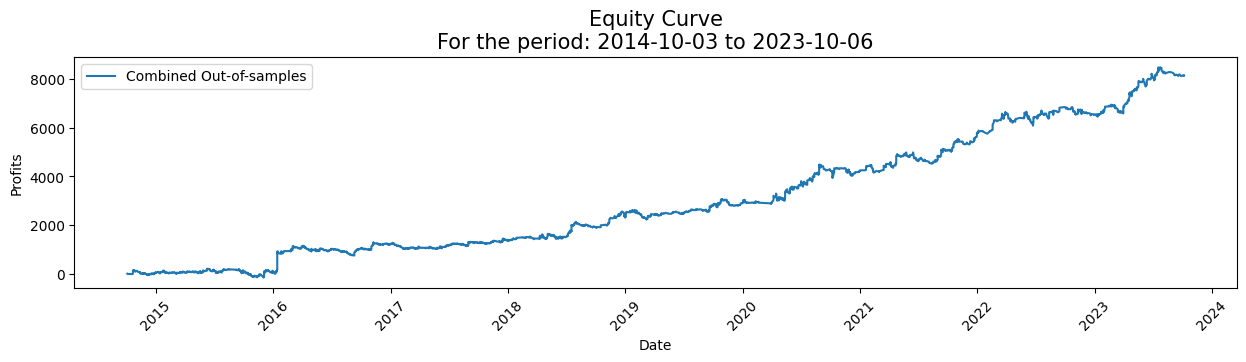

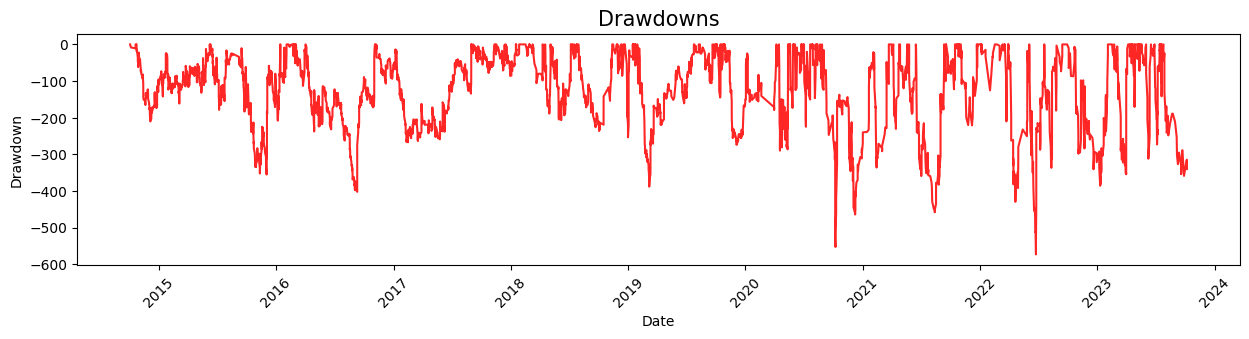

In [14]:
# ----------------------------------
# Plot the entire equity curve
# ----------------------------------
_first_day = df_oos_equitycurve.index[0].strftime("%Y-%m-%d")
_last_day = df_oos_equitycurve.index[-1].strftime("%Y-%m-%d")
_plot_equity_curve(df_oos_equitycurve, remarks="For the period: {} to {}".format(_first_day, _last_day))  

plt.show()

##### Aggregate by day:

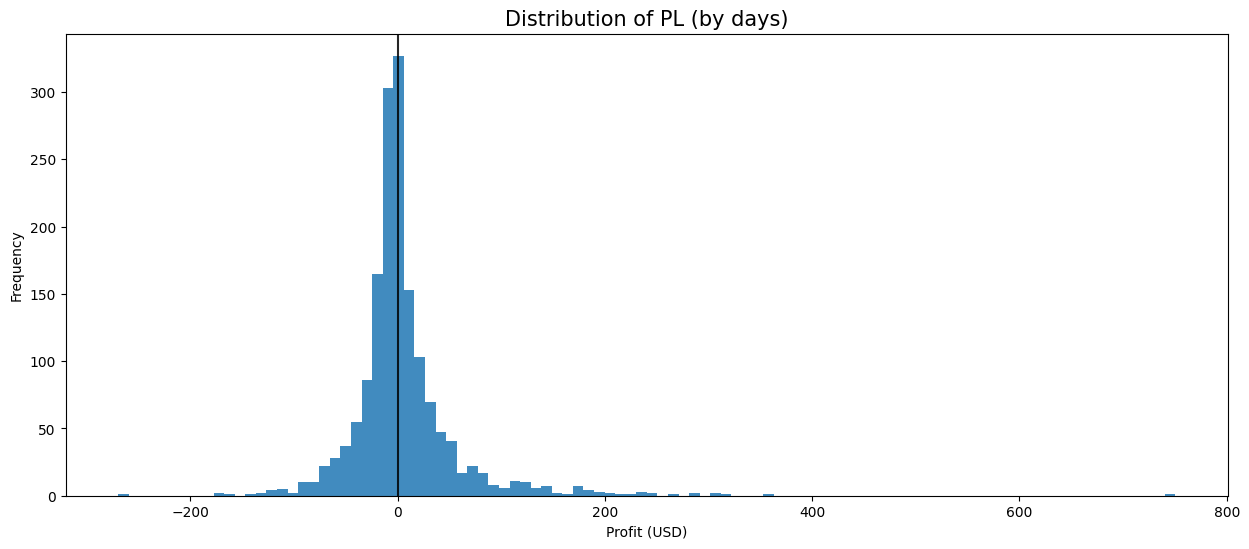

********************
 Daily stats:
********************
Win rate = 0.5163
Winning days = 0.4458


,Profit USD
count,1613.000000
mean,5.045939
std,52.977658


In [15]:
df_pl_daily = df_oos_equitycurve.copy()
df_pl_daily['YYYYMMDD'] = df_pl_daily.index.strftime("%Y%m%d")
df_pl_daily = df_pl_daily.groupby(['YYYYMMDD']).agg({'Profit USD':'sum'})

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)

ax.hist(df_pl_daily['Profit USD'], bins=100, alpha=0.85)
ax.axvline(x=0, color='black', alpha=0.85)
ax.set_title('Distribution of PL (by days)', size=15)
ax.set_xlabel('Profit (USD)')
ax.set_ylabel('Frequency')

plt.show()

# Print stats
print("*"*20), print(" Daily stats:"), print("*"*20)
print("Win rate = " + str(round(len(df_oos_equitycurve[df_oos_equitycurve["Profit USD"] > 0]) / len(df_oos_equitycurve),4)))
print("Winning days = " + str(round(len(df_pl_daily[df_pl_daily["Profit USD"] > 0]) / len(df_pl_daily),4)))
df_pl_daily.describe()[:3]

All time calmar:  3.1028457627335344


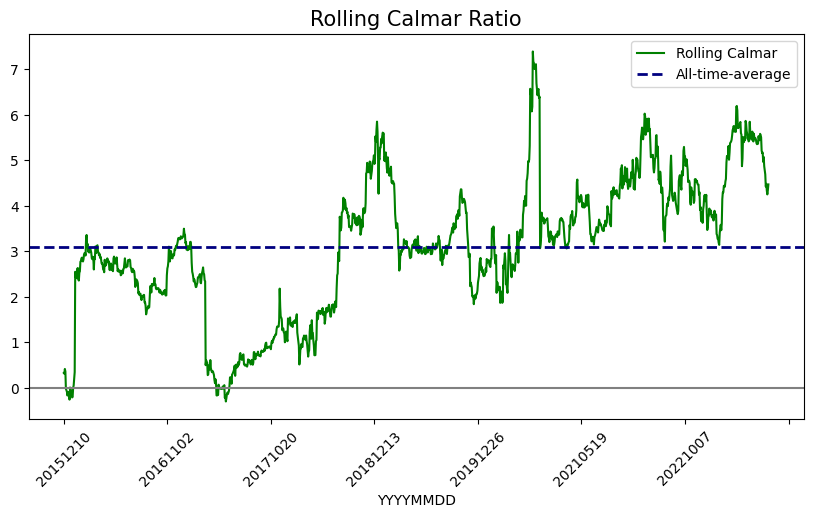

In [16]:
df = df_pl_daily.copy()
df['Accum PL'] = df['Profit USD'].cumsum()
df['Drawdown'] = df['Accum PL'] - df['Accum PL'].cummax() 

# Rolling calmar ratio
df['Rolling Calmar'] = df['Profit USD'].rolling(252).mean() / df['Drawdown'].rolling(252).min()*-1 * 252
df['Rolling Calmar'].dropna().plot(figsize=(10,5), color='green' )

# All time calmar
all_time_calmar = df['Rolling Calmar'].mean()
plt.axhline(all_time_calmar, color='navy', linestyle='--', label='All-time-average', linewidth=2) 
print("All time calmar: ", all_time_calmar)
plt.title('Rolling Calmar Ratio', fontsize=15)

# Rotate xticks
plt.xticks(rotation=45)
plt.legend()
plt.axhline(0, color='gray') # horizontal line at 0
plt.show()

##### Output files:
* (1) pickel file for ML models
* (2) .csv file containing list of combined OOS periods

In [17]:
# Change directory to dir_notebook_location and save the dataframes as pickle and csv files
os.chdir(dir_notebook_location) 
df_wfa_template.to_pickle('output_wfa.pkl')
df_oos_equitycurve.to_csv('equity_curve_outofsample_dataset_XXX.csv')

##### Monte Carlo Simulations
Objectives: 
* (1) To visualize upside/downside., and 
* (2) To validate the shape of the distribution of of PL (by days) 

In [18]:
daily_simulations = _monte_carlo_equity_curve(df_pl_daily, n_simulations=20000, n_forecast=252)
daily_simulations = np.array(daily_simulations)
print("Shape of daily_simulations: ", daily_simulations.shape)

Shape of daily_simulations:  (20000, 253)


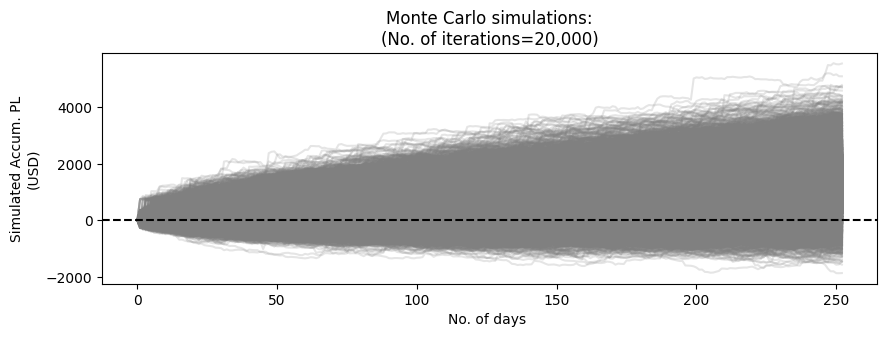

In [19]:
# Plot the MCS
plt.figure(figsize=(10,3))
plt.plot(daily_simulations.T, color='gray', alpha=0.2)
plt.title("Monte Carlo simulations:\n(No. of iterations={:,})".format(daily_simulations.shape[0]))
plt.xlabel("No. of days ")
plt.ylabel("Simulated Accum. PL\n(USD)") 
plt.axhline(0, color='black', linestyle='--') 
plt.show()

##### Expected returns

In [20]:
_initial_capital = 2000
expected_return = np.mean(daily_simulations[252:])
print("E(r) = ", expected_return)
print("E(r) = ", expected_return/_initial_capital*100, "%")

E(r) =  642.472310279482
E(r) =  32.1236155139741 %


##### WFA Settings

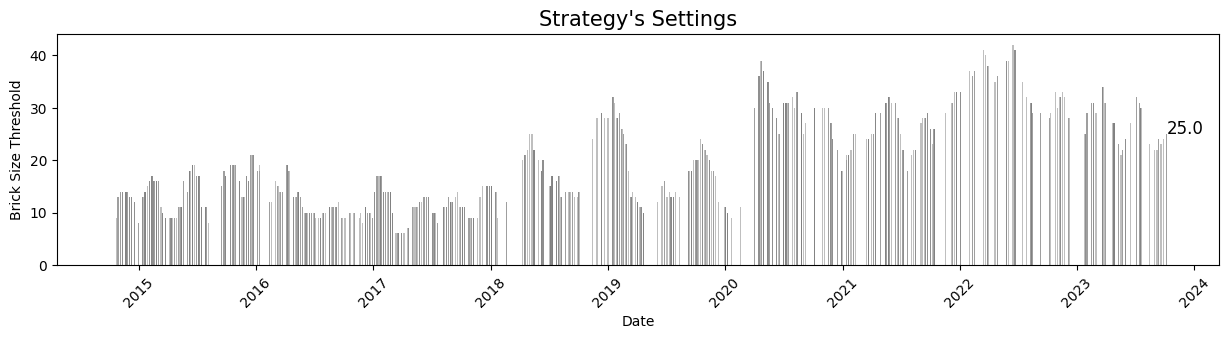

In [21]:
fig = plt.figure(figsize=(15, 3)) 
opt_params = df_oos_equitycurve['Params'].str.extract('Brick=(\d+)')
opt_params = opt_params.astype(float)

plt.bar(opt_params.index, opt_params.iloc[:,0], color='gray', alpha=0.5)
plt.title("Strategy's Settings", size=15)
plt.xlabel("Date")
plt.ylabel("Brick Size Threshold")
plt.xticks(rotation=45)

# Label the value at the end of the time series
plt.text(x=opt_params.index[-1], y=opt_params.iloc[-1,0], s=round(opt_params.iloc[-1,0],2), fontsize=12) 

plt.show()